In [1]:
import os
import matplotlib.image as mpimg

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import StackingRegressor

if str(os.getcwdb()[-3:]).split("'")[1] != 'src':
    for _ in range(2):
        os.chdir(os.path.dirname(os.getcwdb()))

from utils.classes import *
from utils.functions import *


In [2]:
df_diamonds = pd.read_csv(r'data\processed\competition\train_processed.csv', index_col='id')
df_predict = pd.read_csv(r'data\processed\competition\test_processed.csv', index_col='id')


In [3]:
# Se hacen las preparaciones necesarias
Regression.add_models('XGBRegressor')

rmse = make_scorer(calculate_rmse, greater_is_better=False)
kfolds = KFold(n_splits=5, shuffle=True, random_state=43)


# Introducción

- Como se ha visto en "Feature_engineering", el mejor modelo es "XGBRegressor"

- Si bien se le ha sacado bastante partido con varios parámetros, aún quedan muchas combinaciones por probar

- Se usa el "dataframe" de competición para ganar la competición, y el "dataframe" original para predecir los precios en la "app"

- Del "dataframe" de competición sale un único modelo "xgb"

- El "dataframe" para predecir precios son, en realidad, dos "dataframes": uno con la variable "table" y otro sin ella (para poder predecir los precios a partir de las características de las fotos). 

- De cada uno de esos "dataframes" de precios sale un modelo "xgboost". Sin embargo, como "xgboost" y los de árboles no predicen bien con valores fuera del rango introducido durante el entrenamiento, se utiliza un segundo modelo para cada "dataframe", que predice peor pero que es capaz de evaluar fuera de rango, y se fusionan los dos en cada caso mediante "stacking". Los dos modelos resultantes se usarán en la "app" para predecir el precio

# Mejoras para competición

- A continuación, se experimenta de forma extensiva con "XGB" con tal de obtener los mejores resultados posibles

- El modelo resultante es el que se usa para la competición


## Ronda 1: base
- Esta primera ronda, sin modificación alguna, se lleva a cabo solo para poder ir comparando las mejoras 

In [4]:
df_1 = df_diamonds.copy()

round_1 = Regression(df_diamonds, 'price')
X_train, X_test, y_train, y_test = round_1.split_dataframe()
round_1.prepare_models(params_list=[['XGBRegressor', 'random_state=43']])
round_1.apply_and_evaluate_kfolds()
round_1.create_dataframe()


-- Regression: using mean of 5 folds --
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 7.0 sec(s). Total time: 7.0


,XGBRegressor: random_state=43
mae,0.065596
mape,0.008468
mse,0.008247
r2_score,0.991976
rmse,0.090762


## Ronda 2: solo cambios

- Similar a la anterior, esta ronda solo con los cambios descubiertos en "Feature_engineering" sirve de punto de partida

In [13]:
df_cambios = df_diamonds.copy()

df_cambios = remove_all(df_cambios, zeros_only=True)
df_cambios = assign_values(df_cambios, outlier=False)

df_2 = df_cambios.copy()

round_2 = Regression(df_2, 'price')
X_train, X_test, y_train, y_test = round_2.split_dataframe()
round_2.prepare_models(params_list=[['XGBRegressor', 'random_state=43']])
round_2.apply_and_evaluate_kfolds()
round_2.create_dataframe()


-- Regression: using mean of 5 folds --
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 4.91 sec(s). Total time: 4.91


,XGBRegressor: random_state=43
mae,0.065675
mape,0.008483
mse,0.008221
r2_score,0.992033
rmse,0.090657


## Ronda 3: "eta"

- Como el "dataset" no es muy grande, se reduce el "learning rate" (por defecto, 3) todo lo posible
- Dado que durante el "feature engineering" ha salido un "eta" de 0.1, se mira alrededor de ese número

In [15]:
# Lo primero es elegir el número de estimadores que sirve como punto de partida (196 - 1 = 195)
model = XGBRegressor(booster='gbtree', n_estimators=2000)

model.early_stopping_rounds = 500

model.fit(X_train, y_train, eval_set=[(X_test, y_test)]) 

model.best_ntree_limit


[0]	validation_0-rmse:5.15340
[1]	validation_0-rmse:3.61090
[2]	validation_0-rmse:2.53117
[3]	validation_0-rmse:1.77563
[4]	validation_0-rmse:1.24698
[5]	validation_0-rmse:0.87780
[6]	validation_0-rmse:0.62082
[7]	validation_0-rmse:0.44256
[8]	validation_0-rmse:0.32017
[9]	validation_0-rmse:0.23730
[10]	validation_0-rmse:0.18313
[11]	validation_0-rmse:0.14890
[12]	validation_0-rmse:0.12836
[13]	validation_0-rmse:0.11667
[14]	validation_0-rmse:0.10953
[15]	validation_0-rmse:0.10557
[16]	validation_0-rmse:0.10331
[17]	validation_0-rmse:0.10162
[18]	validation_0-rmse:0.10088
[19]	validation_0-rmse:0.10018
[20]	validation_0-rmse:0.09962
[21]	validation_0-rmse:0.09922
[22]	validation_0-rmse:0.09867
[23]	validation_0-rmse:0.09845
[24]	validation_0-rmse:0.09814
[25]	validation_0-rmse:0.09774
[26]	validation_0-rmse:0.09759
[27]	validation_0-rmse:0.09737
[28]	validation_0-rmse:0.09688
[29]	validation_0-rmse:0.09675
[30]	validation_0-rmse:0.09661
[31]	validation_0-rmse:0.09601
[32]	validation_0-

196

In [ ]:
model = XGBRegressor()

params = {'random_state': [43],
          'booster': ['gbtree'],
          'n_estimators': [195],
          'eta': [0.1, 0.125, 0.15, 0.175, 0.2],
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END booster=gbtree, eta=0.1, n_estimators=195, random_state=43;, score=-0.092 total time=   2.0s
[CV 2/5] END booster=gbtree, eta=0.1, n_estimators=195, random_state=43;, score=-0.091 total time=   1.7s
[CV 3/5] END booster=gbtree, eta=0.1, n_estimators=195, random_state=43;, score=-0.087 total time=   1.7s
[CV 4/5] END booster=gbtree, eta=0.1, n_estimators=195, random_state=43;, score=-0.087 total time=   1.7s
[CV 5/5] END booster=gbtree, eta=0.1, n_estimators=195, random_state=43;, score=-0.089 total time=   1.9s
[CV 1/5] END booster=gbtree, eta=0.125, n_estimators=195, random_state=43;, score=-0.091 total time=   2.0s
[CV 2/5] END booster=gbtree, eta=0.125, n_estimators=195, random_state=43;, score=-0.091 total time=   2.1s
[CV 3/5] END booster=gbtree, eta=0.125, n_estimators=195, random_state=43;, score=-0.087 total time=   1.9s
[CV 4/5] END booster=gbtree, eta=0.125, n_estimators=195, random_state=43;, score=-0.0

In [ ]:
# Con el "eta" ya determinado, se saca un nuevo número óptimo de estimadores (532 - 1 = 531)
model = XGBRegressor(booster='gbtree', eta=0.15, n_estimators=2000)

model.early_stopping_rounds = 500

model.fit(X_train, y_train, eval_set=[(X_test, y_test)]) 

model.best_ntree_limit


[0]	validation_0-rmse:6.25481
[1]	validation_0-rmse:5.31758
[2]	validation_0-rmse:4.52146
[3]	validation_0-rmse:3.84486
[4]	validation_0-rmse:3.26999
[5]	validation_0-rmse:2.78099
[6]	validation_0-rmse:2.36548
[7]	validation_0-rmse:2.01256
[8]	validation_0-rmse:1.71259
[9]	validation_0-rmse:1.45772
[10]	validation_0-rmse:1.24104
[11]	validation_0-rmse:1.05718
[12]	validation_0-rmse:0.90112
[13]	validation_0-rmse:0.76859
[14]	validation_0-rmse:0.65630
[15]	validation_0-rmse:0.56107
[16]	validation_0-rmse:0.48058
[17]	validation_0-rmse:0.41249
[18]	validation_0-rmse:0.35531
[19]	validation_0-rmse:0.30726
[20]	validation_0-rmse:0.26704
[21]	validation_0-rmse:0.23362
[22]	validation_0-rmse:0.20596
[23]	validation_0-rmse:0.18320
[24]	validation_0-rmse:0.16485
[25]	validation_0-rmse:0.14995
[26]	validation_0-rmse:0.13801
[27]	validation_0-rmse:0.12861
[28]	validation_0-rmse:0.12114
[29]	validation_0-rmse:0.11550
[30]	validation_0-rmse:0.11118
[31]	validation_0-rmse:0.10787
[32]	validation_0-

532

## Ronda 4: "constraints"

- Se comprueba que el modelo mejora si se aplican "constraints" a "weight (carat)". Se hace de primeras porque se intuye que, en caso de mejorar la métrica, lo hará independientemente del resto de hiperparámetros

- El resultado tiene sentido ya que como se ha visto en el EDA a) tiene una altísima correlación con la "target", y b) cuando un diamante pesa más su precio es superior, y las otras columnas relacionadas con el tamaño se ajustan a ese peso

In [ ]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [531],
          'booster': ['gbtree'],
          'eta': [0.15],
          'monotone_constraints':[{"weight (carat)": 1}, {"lenght (millimeters)": 1}, {"width (millimeters)": 1}, {"depth (millimeters)": 1}],
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END booster=gbtree, eta=0.15, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43;, score=-0.089 total time=   8.1s
[CV 2/5] END booster=gbtree, eta=0.15, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43;, score=-0.089 total time=   7.8s
[CV 3/5] END booster=gbtree, eta=0.15, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43;, score=-0.086 total time=   7.8s
[CV 4/5] END booster=gbtree, eta=0.15, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43;, score=-0.086 total time=   8.4s
[CV 5/5] END booster=gbtree, eta=0.15, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43;, score=-0.087 total time=   8.1s
[CV 1/5] END booster=gbtree, eta=0.15, monotone_constraints={'lenght (millimeters)': 1}, n_estimators=531, random_state=43;, score=-0.090 total time=   7.9s
[CV 2/5] END booster=gbtree,

## Ronda 5: "max_depth" y "min_child_weight"

- Estos son de los hiperparámetros que más influyen y que pueden variar en función del resto, así que se prueban inmediatamente después del "eta"

- Para este fin, se establecen un "subsample" y "colsample_bytree" de 0.8, que es el estándar recomendable 

In [ ]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [531],
          'eta': [0.15],
          'booster': ['gbtree'],
          'monotone_constraints':[{"weight (carat)": 1}],
          'subsample':[0.8],
          'colsample_bytree': [0.8],
          'max_depth': range(4, 8),
          'min_child_weight': range(1, 4)
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, max_depth=4, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.8;, score=-0.092 total time=   5.8s
[CV 2/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, max_depth=4, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.8;, score=-0.089 total time=   5.5s
[CV 3/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, max_depth=4, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.8;, score=-0.087 total time=   5.5s
[CV 4/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, max_depth=4, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.8;, score=-0.088 total time=   5.5s
[CV 5/5] END booster=gbtree, colsample_bytree=0.8, eta=

## Ronda 6: "gamma"

- Acto seguido, se hace lo propio con "gamma". Se hace antes que los de regularización porque se considera de semiregularización


In [ ]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [531],
          'eta': [0.15],
          'booster': ['gbtree'],
          'monotone_constraints':[{"weight (carat)": 1}],
          'subsample':[0.8],
          'colsample_bytree': [0.8],
          'max_depth': [5],
          'min_child_weight': [1],
          'gamma': np.linspace(0, 0.5, num=6)
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0.0, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.8;, score=-0.090 total time=  12.0s
[CV 2/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0.0, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.8;, score=-0.089 total time=  10.1s
[CV 3/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0.0, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.8;, score=-0.087 total time=  10.2s
[CV 4/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0.0, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.8;, score=-0.087 total time=  10.9s
[CV 5/5] END

## Ronda 7: "sampling"

- Acto seguido, hay que reajustar los valores puestos por defecto de "sampling" y "colsample_bytree"

- Se prueban dos opciones: a) "sampling" combinado con "colsample_bytree", y b) "sampling_method='gradient_based" combinado con "colsample_bytree"

In [ ]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [531],
          'booster': ['gbtree'],
          'sampling_method': ['gradient_based'],
          'eta': [0.15],
          'max_depth': [5],
          'min_child_weight': [1],
          'monotone_constraints':[{"weight (carat)": 1}],
          'colsample_bytree': np.linspace(0.5, 1.0, num=6)
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, sampling_method=gradient_based;, score=-0.091 total time=   6.9s
[CV 2/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, sampling_method=gradient_based;, score=-0.090 total time=   5.7s
[CV 3/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, sampling_method=gradient_based;, score=-0.087 total time=   5.4s
[CV 4/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, sampling_method=gradient_based;, score=-0.087 total t

In [ ]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [531],
          'booster': ['gbtree'],
          'eta': [0.15],
          'max_depth': [5],
          'min_child_weight': [1],
          'monotone_constraints':[{"weight (carat)": 1}],
          'subsample': np.linspace(0.5, 1.0, num=6),
          'colsample_bytree': np.linspace(0.5, 1.0, num=6)
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.5;, score=-0.093 total time=   8.2s
[CV 2/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.5;, score=-0.091 total time=   6.6s
[CV 3/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.5;, score=-0.088 total time=   6.6s
[CV 4/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.5;, score=-0.087 total time=   7.9s
[CV 5/5] END booster=gbtree, colsample_bytree=0.5, eta

## Ronda 8: hiperparámetros de regularización

- Como colofón, se tunean los hiperparámetros de regularización; es decir, los que ayudan a prevenir el "overfitting" y el "underfitting"

In [ ]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [531],
          'eta': [0.15],
          'monotone_constraints':[{"weight (carat)": 1}],
          'subsample': [0.8],
          'colsample_bytree': [0.9],
          'max_depth': [5],
          'min_child_weight': [1],
          'max_delta_step': range(0, 6),
          'lambda': np.linspace(0, 1, num=6),
          'reg_alpha': np.linspace(0, 1, num=6)
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 1/5] END colsample_bytree=0.9, eta=0.15, lambda=0.0, max_delta_step=0, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, reg_alpha=0.0, subsample=0.8;, score=-0.090 total time=   8.0s
[CV 2/5] END colsample_bytree=0.9, eta=0.15, lambda=0.0, max_delta_step=0, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, reg_alpha=0.0, subsample=0.8;, score=-0.090 total time=   7.2s
[CV 3/5] END colsample_bytree=0.9, eta=0.15, lambda=0.0, max_delta_step=0, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, reg_alpha=0.0, subsample=0.8;, score=-0.087 total time=   7.2s
[CV 4/5] END colsample_bytree=0.9, eta=0.15, lambda=0.0, max_delta_step=0, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43,

## Ronda 9: "num_parallel_tree"

- Una vez seleccionados los mejores hiperparámetros, se modifica el número de árboles en paralelo con los que se va a trabajar. Esto se hace en este punto porque multiplica el coste computacional, convirtiendo cada iteración en un "RandomForest"

In [ ]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [531],
          'eta': [0.15],
          'monotone_constraints':[{"weight (carat)": 1}],
          'subsample': [0.8],
          'colsample_bytree': [0.9],
          'max_depth': [5],
          'min_child_weight': [1],
          'max_delta_step': [3],
          'lambda': [0.6],
          'reg_alpha': [0.2],
          'num_parallel_tree': range(4, 9)
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END colsample_bytree=0.9, eta=0.15, lambda=0.6, max_delta_step=3, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, num_parallel_tree=4, random_state=43, reg_alpha=0.2, subsample=0.8;, score=-0.089 total time=  27.3s
[CV 2/5] END colsample_bytree=0.9, eta=0.15, lambda=0.6, max_delta_step=3, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, num_parallel_tree=4, random_state=43, reg_alpha=0.2, subsample=0.8;, score=-0.088 total time=  27.8s
[CV 3/5] END colsample_bytree=0.9, eta=0.15, lambda=0.6, max_delta_step=3, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, num_parallel_tree=4, random_state=43, reg_alpha=0.2, subsample=0.8;, score=-0.085 total time=  27.4s
[CV 4/5] END colsample_bytree=0.9, eta=0.15, lambda=0.6, max_delta_step=3, max_depth=5, min_child_weight=1, monotone_constraint

## Ronda 10: reajuste de estimadores

- Con todo lo hecho, se vuelve a ajustar el número óptimo de estimadores

In [ ]:
# El número de estimadores idóneo es 746, y se obtiene de dividir 5229 entre el número de árboles en paralelo (7) y restarle 1 al resultado
model = XGBRegressor(n_estimators=2000, 
                        eta=0.15,
                        monotone_constraints={"weight (carat)": 1}, 
                        subsample=0.8, 
                        colsample_bytree=0.9, 
                        max_depth=5, 
                        min_child_weight=1, 
                        max_delta_step=3,
                        gamma=0,
                        reg_lambda=0.6,
                        reg_alpha=0.2,
                        num_parallel_tree=7
                    )

model.early_stopping_rounds = 300

model.fit(X_train, y_train, eval_set=[(X_test, y_test)]) 

model.best_ntree_limit


[0]	validation_0-rmse:6.91111
[1]	validation_0-rmse:6.46637
[2]	validation_0-rmse:6.02240
[3]	validation_0-rmse:5.57940
[4]	validation_0-rmse:5.13762
[5]	validation_0-rmse:4.69740
[6]	validation_0-rmse:4.25922
[7]	validation_0-rmse:3.82636
[8]	validation_0-rmse:3.40797
[9]	validation_0-rmse:3.00614
[10]	validation_0-rmse:2.62510
[11]	validation_0-rmse:2.26826
[12]	validation_0-rmse:1.94434
[13]	validation_0-rmse:1.65821
[14]	validation_0-rmse:1.41224
[15]	validation_0-rmse:1.20341
[16]	validation_0-rmse:1.02644
[17]	validation_0-rmse:0.87621
[18]	validation_0-rmse:0.74888
[19]	validation_0-rmse:0.64092
[20]	validation_0-rmse:0.54964
[21]	validation_0-rmse:0.47246
[22]	validation_0-rmse:0.40734
[23]	validation_0-rmse:0.35249
[24]	validation_0-rmse:0.30657
[25]	validation_0-rmse:0.26814
[26]	validation_0-rmse:0.23632
[27]	validation_0-rmse:0.20999
[28]	validation_0-rmse:0.18843
[29]	validation_0-rmse:0.17091
[30]	validation_0-rmse:0.15668
[31]	validation_0-rmse:0.14516
[32]	validation_0-

5229

# Resolución de competición

- Se hace una última predicción de prueba y se envía la definitiva a Kaggle, que supera el resultado ganador de la competición

In [ ]:
# Se lleva a cabo la predicción de prueba
model = XGBRegressor(colsample_bytree=0.9, 
                        eta=0.15,
                        reg_lambda=0.6,
                        max_delta_step=3,
                        max_depth=5,
                        min_child_weight=1,
                        monotone_constraints={'weight (carat)': 1},
                        n_estimators=746,
                        num_parallel_tree=7,
                        reg_alpha=0.2,
                        subsample=0.8
                    )

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mean_squared_error(y_test, y_pred, squared=False)


0.08589443942440682

In [ ]:
# Se entrena el modelo para la competición
entrega = Regression(df_cambios, 'price')

X, y = entrega.split_dataframe(return_entire_Xy=True)

model = XGBRegressor(colsample_bytree=0.9, 
                     eta=0.15,
                     reg_lambda=0.6,
                     max_delta_step=3,
                     max_depth=5,
                     min_child_weight=1,
                     monotone_constraints={'weight (carat)': 1},
                     n_estimators=746,
                     num_parallel_tree=7,
                     reg_alpha=0.2,
                     subsample=0.8,
                    )

model.fit(X, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eta=0.15, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=3, max_depth=5,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints={'weight (carat)': 1}, n_estimators=746,
             n_jobs=None, num_parallel_tree=7, predictor=None, ...)

In [ ]:
prediction = model.predict(df_predict)

submission = pd.DataFrame({"id": range(len(prediction)), 'price': prediction})

submission.head()


,id,price
0,0,6.025630
1,1,8.553664
2,2,9.555311
3,3,7.863344
4,4,8.923466


In [ ]:
# Se guarda en un archivo adecuado para subir a para Kaggle
submission.to_csv(r'kaggle_submissions\competition_dataset\submission_file.csv', index=False)


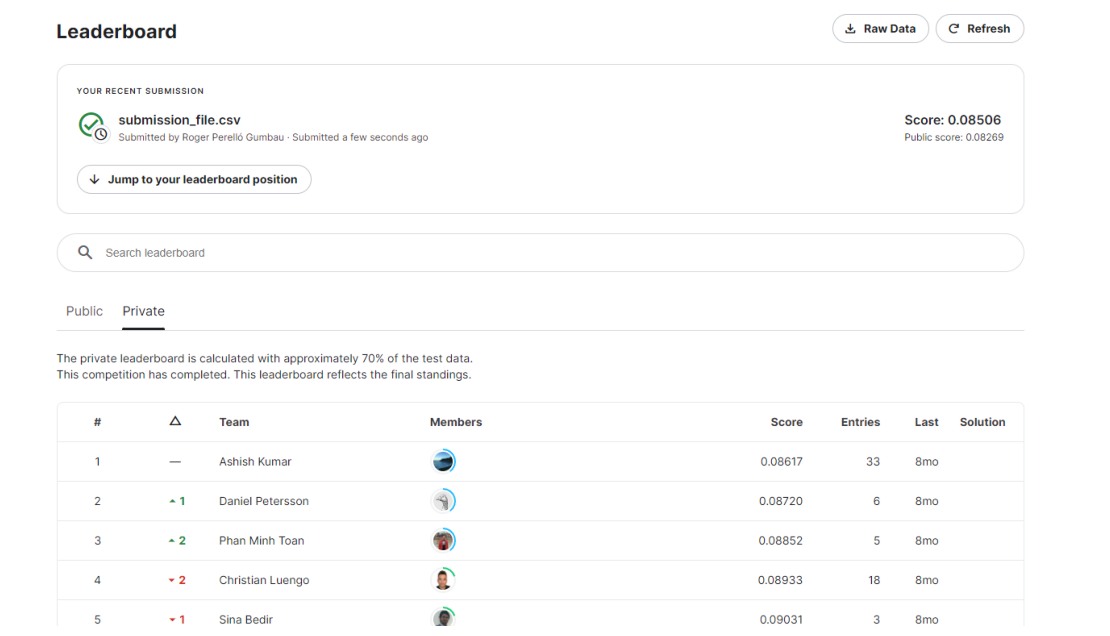

In [ ]:
# Se recibe la puntuación final
plt.rc("figure", figsize=(16, 8))

img = mpimg.imread(r'kaggle_submissions\competition_dataset\result.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()


# Mejoras para visualización A

- Como en el "dataframe" sobre las imágenes no hay datos sobre la "table", toca repetir el proceso pero, esta vez, sin la columna "table (percentage)" con tal de poder relacionar los dos modelos (el de detección de características a través de las imágenes y el de predicción de precios). Se hace, además, con el "dataframe" original y no el de competición, para obtener unos precios más precisos

- Sin embargo, este modelo solo sirve para las predicciones cuando las variables que se le pasan están dentro de los rangos que se ven durante el entrenamiento. Por tanto, hay que entrenar un modelo más para predecir fuera de esos rangos (ver en "Mejoras para visualización B")


## Ronda visualización A 1: solo cambios

- Esta ronda solo sirve como referencia

- Se aplica el logaritmo a la columna "target" para que se asemeje todo lo posible al modelo probado con éxito y así facilitar el proceso de selección de hiperparámetros. A la "target" de competición también le aplicaron el logaritmo, pero borraron decimales; de ahí que se utilice el "dataframe" original, que es más preciso


In [4]:
df_visualizacion = pd.read_csv(r'data\processed\original_processed.csv')

df_visualizacion = remove_all(df_visualizacion, zeros_only=True)
df_visualizacion = assign_values(df_visualizacion, outlier=False)

df_visualizacion['price'] = np.log(df_visualizacion['price'])

round_vis_1a = Regression(df_visualizacion, 'price')
X_train, X_test, y_train, y_test = round_vis_1a.split_dataframe()
round_vis_1a.prepare_models(params_list=[['XGBRegressor', 'random_state=43']])
round_vis_1a.apply_and_evaluate_kfolds()
round_vis_1a.create_dataframe()


-- Regression: using mean of 5 folds --
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 7.0 sec(s). Total time: 7.0


,XGBRegressor: random_state=43
mae,0.065440
mape,0.008439
mse,0.008225
r2_score,0.992022
rmse,0.090688


## Ronda visualización A 2: "eta"

In [23]:
model = XGBRegressor(booster='gbtree', n_estimators=2000)

model.early_stopping_rounds = 500

model.fit(X_train, y_train, eval_set=[(X_test, y_test)]) 

model.best_ntree_limit


[0]	validation_0-rmse:5.14884
[1]	validation_0-rmse:3.60715
[2]	validation_0-rmse:2.52800
[3]	validation_0-rmse:1.77307
[4]	validation_0-rmse:1.24491
[5]	validation_0-rmse:0.87628
[6]	validation_0-rmse:0.61931
[7]	validation_0-rmse:0.44158
[8]	validation_0-rmse:0.31903
[9]	validation_0-rmse:0.23655
[10]	validation_0-rmse:0.18214
[11]	validation_0-rmse:0.14797
[12]	validation_0-rmse:0.12737
[13]	validation_0-rmse:0.11530
[14]	validation_0-rmse:0.10839
[15]	validation_0-rmse:0.10454
[16]	validation_0-rmse:0.10214
[17]	validation_0-rmse:0.10081
[18]	validation_0-rmse:0.09995
[19]	validation_0-rmse:0.09913
[20]	validation_0-rmse:0.09777
[21]	validation_0-rmse:0.09732
[22]	validation_0-rmse:0.09704
[23]	validation_0-rmse:0.09645
[24]	validation_0-rmse:0.09579
[25]	validation_0-rmse:0.09557
[26]	validation_0-rmse:0.09520
[27]	validation_0-rmse:0.09459
[28]	validation_0-rmse:0.09416
[29]	validation_0-rmse:0.09389
[30]	validation_0-rmse:0.09362
[31]	validation_0-rmse:0.09355
[32]	validation_0-

258

In [24]:
model = XGBRegressor()

params = {'random_state': [43],
          'booster': ['gbtree'],
          'n_estimators': [257],
          'eta': [0.025, 0.050, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4],
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END booster=gbtree, eta=0.025, n_estimators=257, random_state=43;, score=-0.095 total time=   4.1s
[CV 2/5] END booster=gbtree, eta=0.025, n_estimators=257, random_state=43;, score=-0.094 total time=   2.9s
[CV 3/5] END booster=gbtree, eta=0.025, n_estimators=257, random_state=43;, score=-0.095 total time=   3.0s
[CV 4/5] END booster=gbtree, eta=0.025, n_estimators=257, random_state=43;, score=-0.096 total time=   2.7s
[CV 5/5] END booster=gbtree, eta=0.025, n_estimators=257, random_state=43;, score=-0.096 total time=   2.9s
[CV 1/5] END booster=gbtree, eta=0.05, n_estimators=257, random_state=43;, score=-0.089 total time=   2.9s
[CV 2/5] END booster=gbtree, eta=0.05, n_estimators=257, random_state=43;, score=-0.089 total time=   3.1s
[CV 3/5] END booster=gbtree, eta=0.05, n_estimators=257, random_state=43;, score=-0.090 total time=   4.9s
[CV 4/5] END booster=gbtree, eta=0.05, n_estimators=257, random_state=43;, sco

In [25]:
model = XGBRegressor(booster='gbtree', eta=0.15, n_estimators=2000)

model.early_stopping_rounds = 500

model.fit(X_train, y_train, eval_set=[(X_test, y_test)]) 

model.best_ntree_limit


[0]	validation_0-rmse:6.24985
[1]	validation_0-rmse:5.31353
[2]	validation_0-rmse:4.51780
[3]	validation_0-rmse:3.84147
[4]	validation_0-rmse:3.26664
[5]	validation_0-rmse:2.77801
[6]	validation_0-rmse:2.36273
[7]	validation_0-rmse:2.00980
[8]	validation_0-rmse:1.70985
[9]	validation_0-rmse:1.45505
[10]	validation_0-rmse:1.23870
[11]	validation_0-rmse:1.05495
[12]	validation_0-rmse:0.89909
[13]	validation_0-rmse:0.76671
[14]	validation_0-rmse:0.65451
[15]	validation_0-rmse:0.55950
[16]	validation_0-rmse:0.47916
[17]	validation_0-rmse:0.41124
[18]	validation_0-rmse:0.35410
[19]	validation_0-rmse:0.30609
[20]	validation_0-rmse:0.26575
[21]	validation_0-rmse:0.23230
[22]	validation_0-rmse:0.20464
[23]	validation_0-rmse:0.18202
[24]	validation_0-rmse:0.16350
[25]	validation_0-rmse:0.14862
[26]	validation_0-rmse:0.13660
[27]	validation_0-rmse:0.12717
[28]	validation_0-rmse:0.11987
[29]	validation_0-rmse:0.11420
[30]	validation_0-rmse:0.10982
[31]	validation_0-rmse:0.10651
[32]	validation_0-

420

## Ronda visualización A 3: "constraints"

- Como se ha visto que solo puede mejorar con "weight", se comprueba únicamente si realmente sigue ocurriendo con esa columna

In [26]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [419],
          'booster': ['gbtree'],
          'eta': [0.15],
          'monotone_constraints':[{"weight (carat)": 1}],
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END booster=gbtree, eta=0.15, monotone_constraints={'weight (carat)': 1}, n_estimators=419, random_state=43;, score=-0.087 total time=   9.7s
[CV 2/5] END booster=gbtree, eta=0.15, monotone_constraints={'weight (carat)': 1}, n_estimators=419, random_state=43;, score=-0.087 total time=   8.4s
[CV 3/5] END booster=gbtree, eta=0.15, monotone_constraints={'weight (carat)': 1}, n_estimators=419, random_state=43;, score=-0.087 total time=   8.2s
[CV 4/5] END booster=gbtree, eta=0.15, monotone_constraints={'weight (carat)': 1}, n_estimators=419, random_state=43;, score=-0.088 total time=   8.1s
[CV 5/5] END booster=gbtree, eta=0.15, monotone_constraints={'weight (carat)': 1}, n_estimators=419, random_state=43;, score=-0.088 total time=   7.6s
Best params: {'booster': 'gbtree', 'eta': 0.15, 'monotone_constraints': {'weight (carat)': 1}, 'n_estimators': 419, 'random_state': 43}
Best score: -0.08739281388487445


## Ronda visualización A 4: "max_depth" y "min_child_weight"

In [29]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [419],
          'eta': [0.15],
          'booster': ['gbtree'],
          'monotone_constraints': [{'weight (carat)': 1}],
          'subsample':[0.8],
          'colsample_bytree': [0.8],
          'max_depth': range(1, 11),
          'min_child_weight': range(1, 11)
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, max_depth=1, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=419, random_state=43, subsample=0.8;, score=-0.121 total time=   2.9s
[CV 2/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, max_depth=1, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=419, random_state=43, subsample=0.8;, score=-0.120 total time=   2.5s
[CV 3/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, max_depth=1, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=419, random_state=43, subsample=0.8;, score=-0.122 total time=   2.9s
[CV 4/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, max_depth=1, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=419, random_state=43, subsample=0.8;, score=-0.121 total time=   2.6s
[CV 5/5] END booster=gbtree, colsample_bytree=0.8, et

## Ronda visualización A 5: "gamma"

In [7]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [419],
          'eta': [0.15],
          'booster': ['gbtree'],
          'monotone_constraints':[{"weight (carat)": 1}],
          'subsample':[0.8],
          'colsample_bytree': [0.8],
          'max_depth': [6],
          'min_child_weight': [4],
          'gamma': np.linspace(0, 1, num=11)
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0.0, max_depth=6, min_child_weight=4, monotone_constraints={'weight (carat)': 1}, n_estimators=419, random_state=43, subsample=0.8;, score=-0.087 total time=  11.1s
[CV 2/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0.0, max_depth=6, min_child_weight=4, monotone_constraints={'weight (carat)': 1}, n_estimators=419, random_state=43, subsample=0.8;, score=-0.087 total time=   9.8s
[CV 3/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0.0, max_depth=6, min_child_weight=4, monotone_constraints={'weight (carat)': 1}, n_estimators=419, random_state=43, subsample=0.8;, score=-0.087 total time=  10.0s
[CV 4/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0.0, max_depth=6, min_child_weight=4, monotone_constraints={'weight (carat)': 1}, n_estimators=419, random_state=43, subsample=0.8;, score=-0.087 total time=   9.6s
[CV 5/5] EN

## Ronda visualización A 6: "sampling"

In [8]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [419],
          'eta': [0.15],
          'booster': ['gbtree'],
          'monotone_constraints':[{"weight (carat)": 1}],
          'subsample': np.linspace(0.5, 1.0, num=6),
          'colsample_bytree': np.linspace(0.5, 1.0, num=6),
          'max_depth': [6],
          'min_child_weight': [4],
          'gamma': [0]
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, gamma=0, max_depth=6, min_child_weight=4, monotone_constraints={'weight (carat)': 1}, n_estimators=419, random_state=43, subsample=0.5;, score=-0.089 total time=   7.8s
[CV 2/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, gamma=0, max_depth=6, min_child_weight=4, monotone_constraints={'weight (carat)': 1}, n_estimators=419, random_state=43, subsample=0.5;, score=-0.088 total time=   7.1s
[CV 3/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, gamma=0, max_depth=6, min_child_weight=4, monotone_constraints={'weight (carat)': 1}, n_estimators=419, random_state=43, subsample=0.5;, score=-0.089 total time=  16.0s
[CV 4/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, gamma=0, max_depth=6, min_child_weight=4, monotone_constraints={'weight (carat)': 1}, n_estimators=419, random_state=43, subsample=0.5;, score=-0.089 total time=   8.0s
[CV 5/5] END boost

## Ronda visualización A 7: hiperparámetros de regularización

In [9]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [419],
          'eta': [0.15],
          'booster': ['gbtree'],
          'monotone_constraints':[{"weight (carat)": 1}],
          'subsample': [0.8],
          'colsample_bytree': [0.8],
          'max_depth': [6],
          'min_child_weight': [4],
          'gamma': [0],
          'max_delta_step': range(0, 6),
          'lambda': np.linspace(0, 1, num=6),
          'reg_alpha': np.linspace(0, 1, num=6)
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0, lambda=0.0, max_delta_step=0, max_depth=6, min_child_weight=4, monotone_constraints={'weight (carat)': 1}, n_estimators=419, random_state=43, reg_alpha=0.0, subsample=0.8;, score=-0.088 total time=  16.0s
[CV 2/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0, lambda=0.0, max_delta_step=0, max_depth=6, min_child_weight=4, monotone_constraints={'weight (carat)': 1}, n_estimators=419, random_state=43, reg_alpha=0.0, subsample=0.8;, score=-0.087 total time=  17.4s
[CV 3/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0, lambda=0.0, max_delta_step=0, max_depth=6, min_child_weight=4, monotone_constraints={'weight (carat)': 1}, n_estimators=419, random_state=43, reg_alpha=0.0, subsample=0.8;, score=-0.088 total time=  17.2s
[CV 4/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0, lambda=0.0, max_delta_step=0, max_depth=6

## Ronda visualización A 8: "num_parallel_tree"

In [11]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [419],
          'eta': [0.15],
          'booster': ['gbtree'],
          'monotone_constraints':[{"weight (carat)": 1}],
          'subsample': [0.8],
          'colsample_bytree': [0.8],
          'max_depth': [6],
          'min_child_weight': [4],
          'gamma': [0],
          'max_delta_step': [5],
          'lambda': [0.8],
          'reg_alpha': [0.6],
          'num_parallel_tree': range(2, 11)
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0, lambda=0.8, max_delta_step=5, max_depth=6, min_child_weight=4, monotone_constraints={'weight (carat)': 1}, n_estimators=419, num_parallel_tree=2, random_state=43, reg_alpha=0.6, subsample=0.8;, score=-0.087 total time=  20.0s
[CV 2/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0, lambda=0.8, max_delta_step=5, max_depth=6, min_child_weight=4, monotone_constraints={'weight (carat)': 1}, n_estimators=419, num_parallel_tree=2, random_state=43, reg_alpha=0.6, subsample=0.8;, score=-0.086 total time=  17.5s
[CV 3/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0, lambda=0.8, max_delta_step=5, max_depth=6, min_child_weight=4, monotone_constraints={'weight (carat)': 1}, n_estimators=419, num_parallel_tree=2, random_state=43, reg_alpha=0.6, subsample=0.8;, score=-0.087 total time=  17.9s
[CV 4/5] END booster=gbtree, colsample_bytree=0.8, e

## Ronda visualización A 9: reajuste de estimadores

In [12]:
model = XGBRegressor(n_estimators=2000, 
                        eta=0.15,
                        monotone_constraints={"weight (carat)": 1}, 
                        subsample=0.8, 
                        colsample_bytree=0.8, 
                        max_depth=6, 
                        min_child_weight=4, 
                        max_delta_step=5,
                        gamma=0,
                        reg_lambda=0.8,
                        reg_alpha=0.6,
                        num_parallel_tree=10
                    )

model.early_stopping_rounds = 300

model.fit(X_train, y_train, eval_set=[(X_test, y_test)]) 

model.best_ntree_limit


[0]	validation_0-rmse:6.60907
[1]	validation_0-rmse:5.86904
[2]	validation_0-rmse:5.14548
[3]	validation_0-rmse:4.45608
[4]	validation_0-rmse:3.81646
[5]	validation_0-rmse:3.24898
[6]	validation_0-rmse:2.76368
[7]	validation_0-rmse:2.35106
[8]	validation_0-rmse:2.00061
[9]	validation_0-rmse:1.70286
[10]	validation_0-rmse:1.44977
[11]	validation_0-rmse:1.23504
[12]	validation_0-rmse:1.05284
[13]	validation_0-rmse:0.89795
[14]	validation_0-rmse:0.76648
[15]	validation_0-rmse:0.65525
[16]	validation_0-rmse:0.56089
[17]	validation_0-rmse:0.48097
[18]	validation_0-rmse:0.41353
[19]	validation_0-rmse:0.35684
[20]	validation_0-rmse:0.30919
[21]	validation_0-rmse:0.26915
[22]	validation_0-rmse:0.23578
[23]	validation_0-rmse:0.20823
[24]	validation_0-rmse:0.18568
[25]	validation_0-rmse:0.16711
[26]	validation_0-rmse:0.15214
[27]	validation_0-rmse:0.14015
[28]	validation_0-rmse:0.13072
[29]	validation_0-rmse:0.12329
[30]	validation_0-rmse:0.11745
[31]	validation_0-rmse:0.11291
[32]	validation_0-

7890

# Resolución de visualización A

- Se lleva a cabo la predicción de prueba con Kaggle. El resultado es espectacular. Sin embargo, como se ha usado el "dataset" original en lugar del de la competición, podría considerarse trampa (los datos del "test" podrían ser muy similares, o incluso los mismos, que los vistos durante el entrenamiento), así que se guarda a parte

- Al crear la "app" y probar con pasarle diferentes combinaciones de valores, se detecta que este modelo no predice bien cuando recibe cifras que superan o que son inferiores a los máximos y mínimos de las variables vistas durante el entrenamiento. Eso ocurre porque los modelos de árboles no son tan precisos en los extremos, y, como se ha notado en "feature_enginerring" y en el EDA, la "r2" es alta, y hay varias variables con una correlación altísima. Por eso, se crea un modelo B de predicción de precios

In [5]:
# Se lleva a cabo la predicción de prueba. A priori, el resultado es incluso mejor que el de la competición
model_A = XGBRegressor(n_estimators=788, 
                        eta=0.15,
                        monotone_constraints={"weight (carat)": 1}, 
                        subsample=0.8, 
                        colsample_bytree=0.8, 
                        max_depth=6, 
                        min_child_weight=4, 
                        max_delta_step=5,
                        gamma=0,
                        reg_lambda=0.8,
                        reg_alpha=0.6,
                        num_parallel_tree=10
                    )

model_A.fit(X_train, y_train)

y_pred = model_A.predict(X_test)

mean_squared_error(y_test, y_pred, squared=False)


0.08420145863298129

In [16]:
# Se prueba con enviarla a Kaggle por si realmente mejora el resultado
prediction = model_A.predict(df_predict.drop(columns='table (percentage)'))

submission = pd.DataFrame({"id": range(len(prediction)), 'price': prediction})

submission.to_csv(r'kaggle_submissions\original_dataset_A\submission_file.csv', index=False)


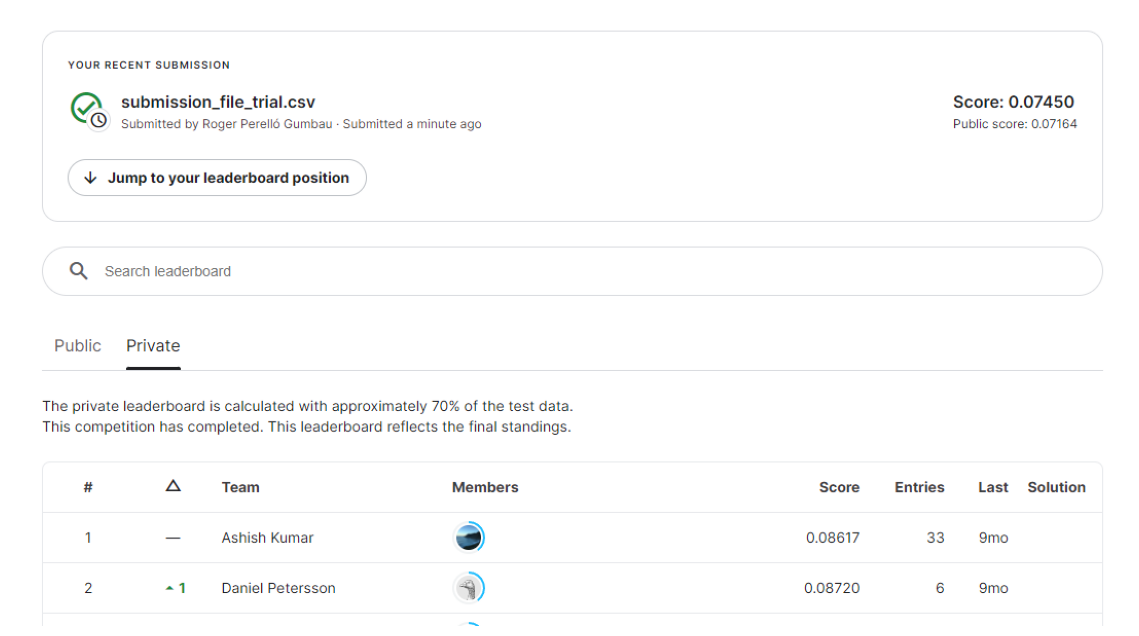

In [17]:
# Lo mejora muchísimo
plt.rc("figure", figsize=(16, 8))

img = mpimg.imread(r'kaggle_submissions\original_dataset_A\result.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()


In [9]:
# El problema de este modelo es que no funciona bien al predecir con valores fuera del rango con el que se le ha entrenado
weight = 7

print(model.predict(np.array([[weight, 2, 3, 4, 5, 6, 7, 8]])))

weight += 9999

print(model.predict(np.array([[weight, 2, 3, 4, 5, 6, 7, 8]])))


[9.683663]
[9.683663]


# Mejoras para visualización B

- Con tal de predecir diamantes cuyas características sean superiores o inferiores a las vistas durante el entrenamiento, se elige el siguiente mejor modelo no "de árboles" detectado durante en "feature_engineering": SVR

- Sin embargo, como el coste computacional de SVC es tan elevado, y se presume que será a aún mayor si se lleva a cabo un "stacking", se elige el siguiente de la lista: k vecinos

- A pesar de lo visto en el "feature_engineering", como se pretende aprovechar el modelo para valores muy altos o bajos a la hora de predecir, interesa entrenarlo con "outliers". Por tanto, no se le hace más tratamiento que el que ha recibido "xgboost"

## Ronda visualización B 1: solo cambios

In [6]:
Regression.remove_models('XGBRegressor')
Regression.add_models('KNeighborsRegressor')

Regression.chosen_models


{'KNeighborsRegressor': ''}

In [7]:
round_vis_1b = Regression(df_visualizacion, 'price')
X_train, X_test, y_train, y_test = round_vis_1b.split_dataframe()
round_vis_1b.prepare_models()
round_vis_1b.apply_and_evaluate_kfolds()
round_vis_1b.create_dataframe()


-- Regression: using mean of 5 folds --
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 3.2 sec(s). Total time: 3.2


,KNeighborsRegressor
mae,0.102514
mape,0.013496
mse,0.019409
r2_score,0.981176
rmse,0.139302


## Ronda visualización B 2: todos

- Se prueban todos los hiperparámetros a la vez porque k vecinos tiene pocos y, con lo visto en "feature_engineering", ya se tiene una idea aproximada de qué puede funcionar

In [33]:
model = KNeighborsRegressor()

params = {'n_neighbors': range(2, 21),
          'weights': ['uniform', 'distance'],
          'algorithm': ['ball_tree'],
          'metric': ['cityblock'],
          'leaf_size': range(1, 26),
          'n_jobs': [-1]
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')


Fitting 5 folds for each of 950 candidates, totalling 4750 fits
[CV 1/5] END algorithm=ball_tree, leaf_size=1, metric=cityblock, n_jobs=-1, n_neighbors=2, weights=uniform;, score=-0.132 total time=   4.2s
[CV 2/5] END algorithm=ball_tree, leaf_size=1, metric=cityblock, n_jobs=-1, n_neighbors=2, weights=uniform;, score=-0.131 total time=   0.5s
[CV 3/5] END algorithm=ball_tree, leaf_size=1, metric=cityblock, n_jobs=-1, n_neighbors=2, weights=uniform;, score=-0.133 total time=   0.5s
[CV 4/5] END algorithm=ball_tree, leaf_size=1, metric=cityblock, n_jobs=-1, n_neighbors=2, weights=uniform;, score=-0.134 total time=   0.5s
[CV 5/5] END algorithm=ball_tree, leaf_size=1, metric=cityblock, n_jobs=-1, n_neighbors=2, weights=uniform;, score=-0.134 total time=   0.4s
[CV 1/5] END algorithm=ball_tree, leaf_size=1, metric=cityblock, n_jobs=-1, n_neighbors=2, weights=distance;, score=-0.132 total time=   0.5s
[CV 2/5] END algorithm=ball_tree, leaf_size=1, metric=cityblock, n_jobs=-1, n_neighbors=2

# Resolución visualización B

- La predicción con el "y_test" es peor, lo que confirma que "xgboost" trabaja mejor que k vecinos con los datos similares a los vistos durante el entrenamiento. Sin embargo, al subirlo a "Kaggle", se dispara. K vecinos es un buen complemento para predecir cuando los valores están fuera de los máximos y mínimos de las variables vistas en el entrenamiento

In [8]:
# Se lleva a cabo la predicción de prueba
model_B = KNeighborsRegressor(algorithm='ball_tree', 
                            leaf_size=2,
                            metric='cityblock', 
                            n_neighbors=12, 
                            weights='distance'
                            )

model_B.fit(X_train, y_train)

y_pred = model_B.predict(X_test)

mean_squared_error(y_test, y_pred, squared=False)


0.11612174039064271

In [36]:
prediction = model_B.predict(df_predict.drop(columns='table (percentage)'))

submission = pd.DataFrame({"id": range(len(prediction)), 'price': prediction})

submission.to_csv(r'kaggle_submissions\original_dataset_B\submission_file.csv', index=False)


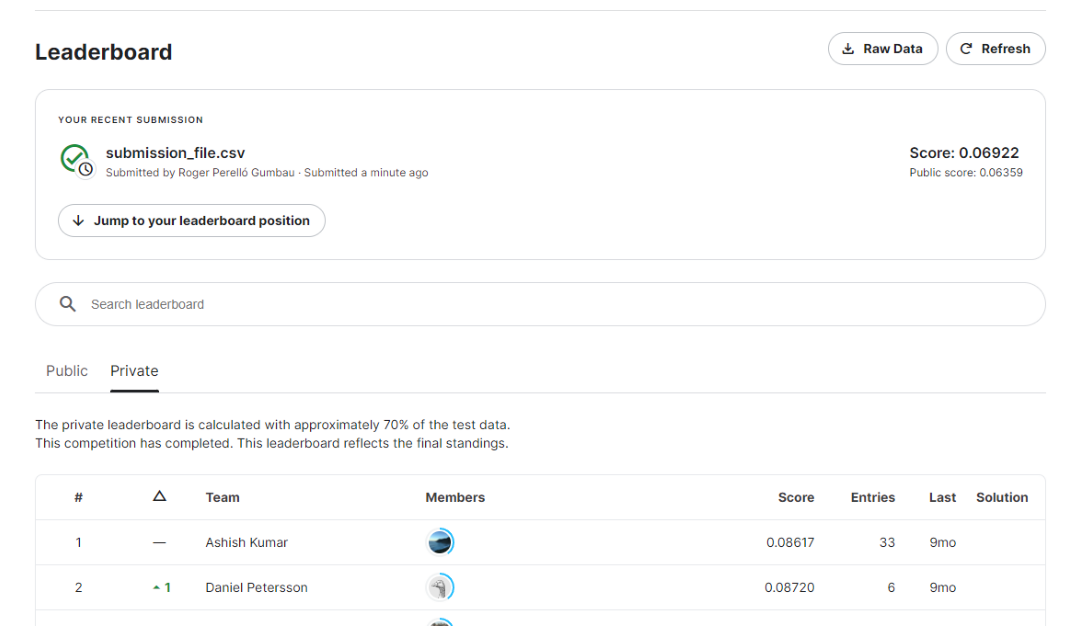

In [37]:
plt.rc("figure", figsize=(16, 8))

img = mpimg.imread(r'kaggle_submissions\original_dataset_B\result.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()


# "Stacking"

- Se intenta combinar las bondades de ambos modelos con un "stacking". Para ello se usa un tercer modelo sencillo de regresión lineal
- El modelo resultante no predice tan bien como "xgboost" (A) ni tan mal como kvecinos (B), pero que es capaz de predecir a partir de valores superiores o inferiores a los máximos y mínimos de las variables vistas durante el entrenamiento
- En todo caso, la predicción con el y_test si que supera a la propia hecha con los modelos A y B
- En conclusión, este es el modelo que se usará para la predicción de precios en la "app"

In [9]:
estimators = [('xgb', model_A), ('knn', model_B)]

stacking = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())


In [10]:
stacking.fit(X_train, y_train)

stacking


StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8,
                                            early_stopping_rounds=None,
                                            enable_categorical=False, eta=0.15,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learni...
                                            max_cat_to_onehot=None,
                                            max_delta_step=5, max_depth=6,
                                            max_leaves=None, min_child_weight=4,
                                            missing=nan,
                                            monotone_constraints={'weight (carat)': 1},
                                            n_estimators=788, n_jobs=None,
                                            num_parallel_tree=10,
                                            predictor=None, ...)),
                              ('knn',
                               KNeighborsRegressor(algorithm='ball_tree',
                                                   leaf_size=2,
                                                   metric='cityblock',
                                                   n_neighbors=12,
                                                   weights='distance'))],
                  final_estimator=LinearRegression())

In [11]:
# Se comprueban esta vez todas las métricas porque se mostrarán en la "app"
y_pred = stacking.predict(X_test)

print(f'rmse: {mean_squared_error(y_test, y_pred, squared=False)}')
print(f'mse: {mean_squared_error(y_test, y_pred)}')
print(f'mae: {mean_absolute_error(y_test, y_pred)}')
print(f'r2: {r2_score(y_test, y_pred)}')
print(f'mape: {mean_absolute_percentage_error(y_test, y_pred)}')


rmse: 0.08419875736401797
mse: 0.007089430741644769
mae: 0.0603800059214286
r2: 0.9930799129228588
mape: 0.007767973088130512


In [12]:
# Se comprueban desescalando los resultados por la misma razón
print(f'rmse: {mean_squared_error(np.exp(y_test), np.exp(y_pred), squared=False)}')
print(f'mse: {mean_squared_error(np.exp(y_test), np.exp(y_pred))}')
print(f'mae: {mean_absolute_error(np.exp(y_test), np.exp(y_pred))}')
print(f'r2: {r2_score(np.exp(y_test), np.exp(y_pred))}')
print(f'mape: {mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred))}')


rmse: 523.0525621927811
mse: 273583.9828164332
mae: 258.97285548898384
r2: 0.9827853649329706
mape: 0.06078645352166642


In [31]:
prediction = stacking.predict(df_predict.drop(columns='table (percentage)'))

submission = pd.DataFrame({"id": range(len(prediction)), 'price': prediction})

submission.to_csv(r'kaggle_submissions\stacking\submission_file.csv', index=False)


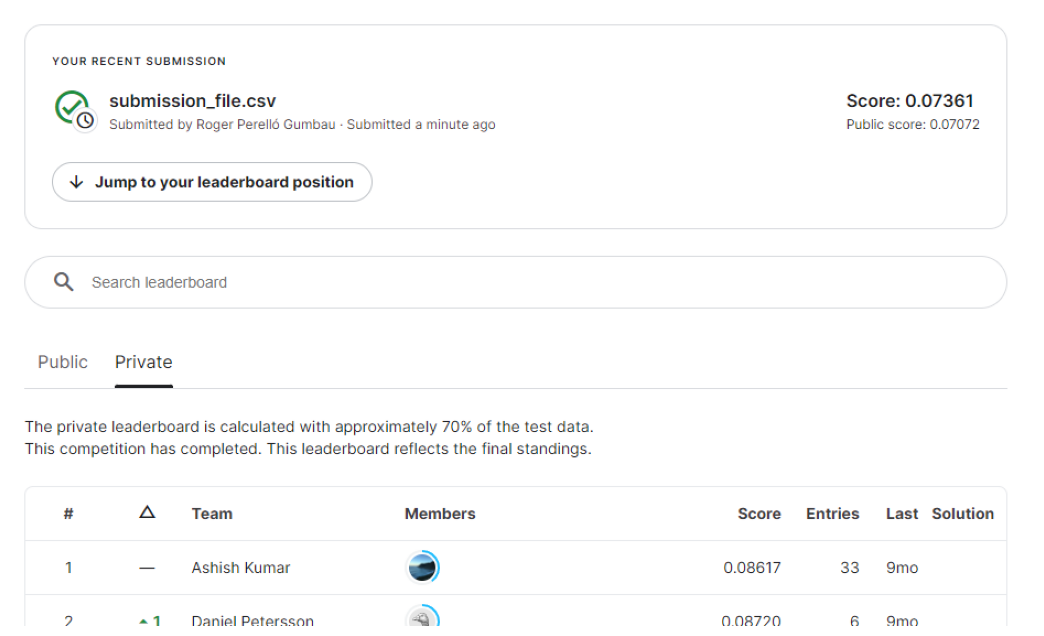

In [32]:
plt.rc("figure", figsize=(16, 8))

img = mpimg.imread(r'kaggle_submissions\stacking\result.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()
